# Wasserstein GAN with Gradient Penalty (WGAN-GP) (Chapter 17)

---

This notebook implements the **Wasserstein GAN with Gradient Penalty (WGAN-GP)**, an advanced generative model designed to overcome the significant training instabilities associated with traditional GANs. By changing the underlying mathematical distance used to compare distributions, WGAN-GP provides a more reliable training signal and helps prevent common issues like "mode collapse."

### 1. The Earth Mover's (Wasserstein) Distance 🌍

Traditional GANs use Binary Cross Entropy, which can lead to vanishing gradients when the discriminator becomes too strong. WGAN-GP replaces this with the **Wasserstein-1 distance**:

* **Critic vs. Discriminator:** In WGAN, the discriminator is renamed the **Critic**. Instead of outputting a probability (0 to 1), it outputs a raw scalar score. The goal is to maximize the distance between the scores of real and fake images.
* **1-Lipschitz Continuity:** For the Wasserstein distance to work, the Critic must be "smooth" (constrained). While early WGANs used weight clipping, this notebook uses the superior **Gradient Penalty** method.



### 2. Gradient Penalty (GP) Implementation ⚖️

The Gradient Penalty is a regularization term added directly to the loss function to enforce the Lipschitz constraint:

* **Interpolated Images:** The model creates "mixed" images by randomly blending real and fake samples.
* **Penalty Calculation:** The gradient of the Critic's score is calculated with respect to these interpolated images. The penalty encourages the norm of these gradients to stay close to **1**.
* **Formula:** `loss_GP = lambda * ((gradients.norm(2, dim=1) - 1) ** 2).mean()`
* **Stability:** This allows the Critic to be trained to optimality without the gradients vanishing or exploding, providing a consistent and meaningful loss curve for the Generator.



### 3. Architectural and Training Shifts ⚙️

Building on the DCGAN architecture, WGAN-GP introduces several critical changes in the training loop:

* **No Sigmoid:** The final layer of the Critic has no activation function (Linear output).
* **Critic Iterations:** For every one update to the Generator, the Critic is updated **5 times** (`n_critic=5`). This ensures the Critic always provides an accurate estimate of the Wasserstein distance.
* **Optimizers:** WGAN-GP typically uses **Adam** (unlike original WGAN which required RMSProp), but with specific tuning to accommodate the Gradient Penalty.
* **No Batch Normalization in Critic:** To ensure the gradient penalty is calculated correctly for each sample independently, **Layer Normalization** or no normalization is used in the Critic, while the Generator continues to use Batch Normalization.

### 4. Convergence Monitoring

A unique benefit of WGAN-GP demonstrated in the notebook is the correlation between loss and quality:
* **Meaningful Loss:** Unlike standard GANs where loss is hard to interpret, the **Critic's loss** in WGAN-GP actually correlates with the visual quality of the generated images. As the loss decreases, the images generally become more realistic.
* **Visual Evolution:** The notebook tracks the transformation of noise into MNIST digits, demonstrating that the WGAN-GP approach reaches high-quality results with much less risk of the training failing midway.

In [ ]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import grad as torch_grad

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

image_path = './'
mnist_dataset = datasets.MNIST(
    root= image_path,
    train= True,
    download= True,
    transform= transform)

In [ ]:
batch_size = 32
mnist_dl = DataLoader(
    mnist_dataset,
    batch_size= batch_size,
    shuffle= False)

In [ ]:
def wgan_generator(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(
          input_size, n_filters * 4, kernel_size= 4, stride= 1, padding= 0, bias= False
          ),
      nn.InstanceNorm2d(n_filters * 4),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters * 4, n_filters * 2, kernel_size= 3, stride= 2, padding= 1, bias= False
          ),
      nn.InstanceNorm2d(n_filters * 2),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters * 2, n_filters, kernel_size= 4, stride= 2, padding= 1, bias= False
      ),
      nn.InstanceNorm2d(n_filters),
      nn.LeakyReLU(0.2),
      nn.ConvTranspose2d(
          n_filters, 1, kernel_size= 4, stride= 2, padding= 1, bias= False
          ),
      nn.Tanh()
  )

  return model

In [ ]:
class DiscriminatorWGAN(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(
            1, n_filters, kernel_size= 4, stride= 2, padding= 1, bias= False
        ),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters, n_filters * 2, kernel_size= 4, stride= 2, padding= 1, bias= False
            ),
        nn.InstanceNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters * 2, n_filters * 4, kernel_size= 3, stride= 2, padding= 1, bias= False
            ),
        nn.InstanceNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            n_filters * 4, 1, kernel_size= 4, stride= 1, padding= 0, bias= False
            ),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)

    return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
n_filters = 32
mode_z = 'uniform'
image_size = (28, 28)
gen_model = wgan_generator(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)
loss_fn = nn.BCELoss()
gen_optimizer = optim.Adam(gen_model.parameters(), lr= 0.0002, betas= (0.5, 0.999))
disc_optimizer = optim.Adam(disc_model.parameters(), lr= 0.0002, betas= (0.5, 0.999))

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1 , 1)*2 - 1
  if mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z

In [ ]:
def create_samples(gen_model, input_z):
  g_output = gen_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  return (images+1)/2.0

In [ ]:
print(gen_model, '\n'*4, disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
) 



 DiscriminatorWGAN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), str

In [ ]:
def gradinet_penalty(real_data, generated_data):
  batch_size = real_data.size(0)
  alpha = torch.rand(real_data.shape[0], 1, 1, 1,
                     requires_grad= True, device= device)
  interpolated = (alpha* real_data) + ((1- alpha) * generated_data)
  interpolated_prob = disc_model(interpolated)
  gradients = torch_grad(
      outputs= interpolated_prob,
      inputs= interpolated,
      grad_outputs= torch.ones(interpolated_prob.size(), device= device),
      create_graph= True,
      retain_graph= True,
  )[0]
  gradients = gradients.view(batch_size, -1)
  gradients_norm = gradients.norm(2, dim= 1)
  return lambda_gp * ((gradients_norm - 1) ** 2).mean()

In [ ]:
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradinet_penalty(x.data, g_output.data)
    d_loss.backward()
    disc_optimizer.step()

    return d_loss.data.item()

In [ ]:
def g_train_wgan(x):
  gen_model.zero_grad()

  batch_size = x.size(0)
  x = x.to(device)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_generated = disc_model(g_output)
  g_loss = -d_generated.mean()
  g_loss.backward()
  gen_optimizer.step()

  return g_loss.data.item()

In [ ]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_wgan_samples = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5
for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses = [], []
  for i, (x, _) in enumerate(mnist_dl):
    for _ in range(critic_iterations):
      d_loss = d_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(g_train_wgan(x))

  print(
      f'Epoch {epoch:03d} | D Loss >>'
      f' {torch.FloatTensor(d_losses).mean():.4f}'
    )
  gen_model.eval()
  epoch_wgan_samples.append(
      create_samples(gen_model, fixed_z).detach().cpu().numpy()
  )

Epoch 001 | D Loss >> -0.3721
Epoch 002 | D Loss >> -0.5244
Epoch 003 | D Loss >> -0.4936
Epoch 004 | D Loss >> -0.4888
Epoch 005 | D Loss >> -0.4741
Epoch 006 | D Loss >> -0.4558
Epoch 007 | D Loss >> -0.4489
Epoch 008 | D Loss >> -0.4418
Epoch 009 | D Loss >> -0.4359
Epoch 010 | D Loss >> -0.4340
Epoch 011 | D Loss >> -0.4323
Epoch 012 | D Loss >> -0.4286
Epoch 013 | D Loss >> -0.4263
Epoch 014 | D Loss >> -0.4275
Epoch 015 | D Loss >> -0.4307
Epoch 016 | D Loss >> -0.4303
Epoch 017 | D Loss >> -0.4350
Epoch 018 | D Loss >> -0.4319
Epoch 019 | D Loss >> -0.4306
Epoch 020 | D Loss >> -0.4344
Epoch 021 | D Loss >> -0.4373
Epoch 022 | D Loss >> -0.4381
Epoch 023 | D Loss >> -0.4397
Epoch 024 | D Loss >> -0.4426
Epoch 025 | D Loss >> -0.4390
Epoch 026 | D Loss >> -0.4413
Epoch 027 | D Loss >> -0.4383
Epoch 028 | D Loss >> -0.4437
Epoch 029 | D Loss >> -0.4410
Epoch 030 | D Loss >> -0.4418
Epoch 031 | D Loss >> -0.4434
Epoch 032 | D Loss >> -0.4448
Epoch 033 | D Loss >> -0.4427
Epoch 034 

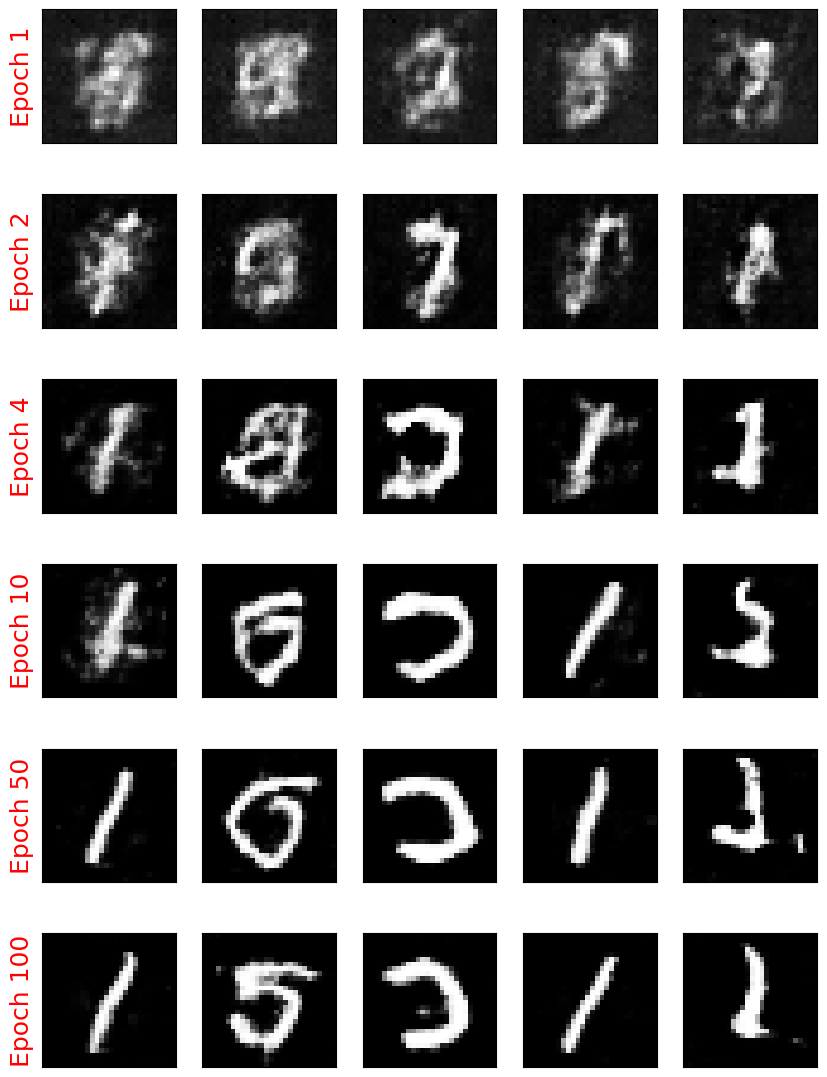

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize= (10, 14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}',
              rotation=90, size=18, color='red',
              horizontalalignment='right',
              verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_wgan_samples[e-1][j]
    ax.imshow(image, cmap= 'gray')

plt.show()